### Plots for RWKV preprint

In [368]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

from pathlib import Path
from typing import Union

In [369]:
BASE_PATH = Path("data/")

In [370]:
def groupby_first_n(df: pd.DataFrame, args: Union[str, list[str]] , n: int = None): #  -> pd.GroupBy: 
    """ Keeps up to the first N in a groupby. If n=None, keeps largest possible. """
    new_df = []
    for els, dfs in df.groupby(args): 
        new_df.append(dfs[:n].sort_values("token_id"))
        print(els, dfs.shape)
    return pd.concat(new_df).groupby(args)

### Cummulative time plot (CUDA)

In [389]:
df = pd.read_csv(BASE_PATH / "inference_results_hf_cuda.csv")
df_rwkv = pd.read_csv(BASE_PATH / "inference_results_rwkv_cuda.csv")

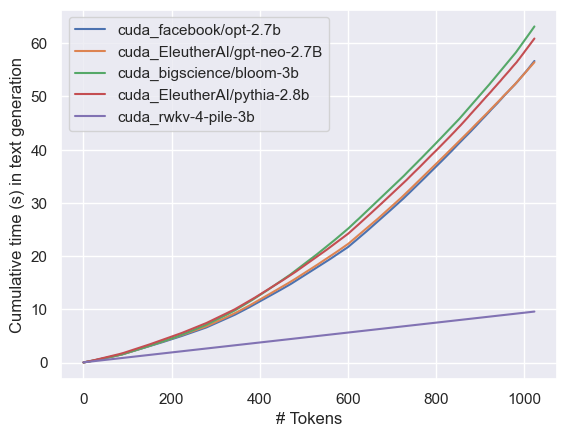

In [390]:
for model_name in ["facebook/opt-2.7b", "EleutherAI/gpt-neo-2.7B", "bigscience/bloom-3b", "EleutherAI/pythia-2.8b",]: 
    plt.plot(np.cumsum(df[df["model_name"] == model_name].cuda_time.values*10**(-6)), label="cuda_"+model_name)
    
plt.plot(np.cumsum(df_rwkv[df_rwkv["model_name"] == "BlinkDL/rwkv-4-pile-3b"].cuda_time.values*10**(-6)), label="cuda_"+"rwkv-4-pile-3b")
plt.legend()
plt.xlabel("# Tokens")
plt.ylabel(f"Cumulative time (s) in text generation")
plt.show()

### Time Plot

In [392]:
df = pd.read_csv(BASE_PATH / "inference_results_hf_cuda.csv")
df_cpu = pd.read_csv(BASE_PATH / "inference_results_hf.csv")
df_cpu = df_cpu[df_cpu.strategy.str.contains("cpu")]
df_rwkv = pd.read_csv(BASE_PATH / "inference_results_rwkv_cuda.csv")
df_rwkv_cpu = pd.read_csv(BASE_PATH / "inference_results_rwkv.csv")
df_rwkv_cpu = df_rwkv_cpu[df_rwkv_cpu.strategy.str.contains("cpu")]

In [393]:
df["time"] = df["cuda_time"]
df_cpu["time"] = df_cpu["cpu_time"]
df_rwkv["time"] = df_rwkv["cuda_time"]
df_rwkv_cpu["time"] = df_rwkv_cpu["cpu_time"]

In [394]:
df = pd.concat([df, df_cpu])
df_rwkv = pd.concat([df_rwkv, df_rwkv_cpu])

In [395]:
max_toks = 512
df_ = groupby_first_n(df, ["model_name", "strategy"], n=max_toks)[["time"]].sum()
df_rwkv_ = groupby_first_n(df_rwkv, ["model_name", "strategy"], n=max_toks)[["time"]].sum()
main_df = pd.concat([df_, df_rwkv_]).reset_index()

In [397]:
scale = {"B": 10**9, "m": 10**6, "b": 10**9}
main_df["model_name"] = main_df["model_name"].str.replace("b5", "b").str.replace("b7", "b")
main_df["class"] = main_df["model_name"].apply(lambda x: '-'.join(x.split("/")[1].split("-")[:-1]))
main_df["size"] = main_df["model_name"].apply(lambda x: float(x.split("-")[-1][:-1]) * scale[x.split("-")[-1][-1]])
main_df["strategy"] = main_df["strategy"].apply(lambda x: "cuda" if "cuda" in x else "cpu")
main_df = main_df.sort_values(["size", "strategy"])

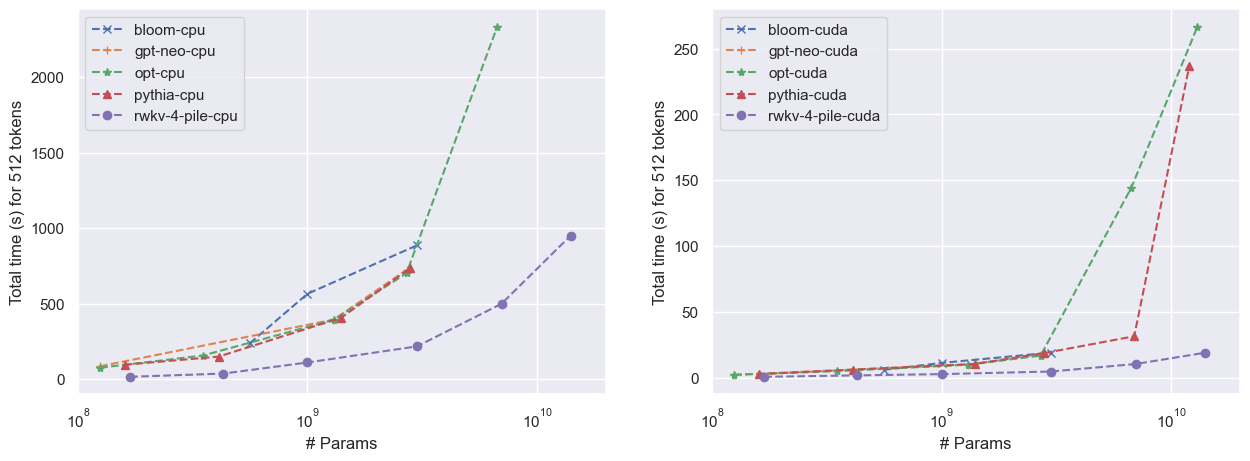

In [398]:
colors = ["r", "b", "g", "y", "k"]
icons = "x+*^o"
alpha = {"cpu": 0.5, "cuda": 1.0}

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

for i, (class_, model_df) in enumerate(main_df.groupby("class")): 
    for s, strategy in enumerate(["cpu", "cuda"]):
        mask = model_df["strategy"] == strategy
        # axs[s].plot(model_df[mask]["size"], model_df[mask]["cpu_time"]*10**(-6), f'{colors[i]}{icons[i]}--', label=f"{class_}-{strategy}")
        axs[s].plot(model_df[mask]["size"], model_df[mask]["time"]*10**(-6), f'{icons[i]}--', label=f"{class_}-{strategy}")

for s in [0, 1]: 
    axs[s].legend()
    axs[s].set_xscale("log")
    # axs[s].set_yscale("log")
    axs[s].set_xlabel("# Params")
    axs[s].set_ylabel(f"Total time (s) for {max_toks} tokens")
    axs[s].set_xlim(10**8, 2.*10**10)
    
plt.savefig("total_inference_time.pdf", format="pdf")

### VRAM plot

In [400]:
df = pd.read_csv(BASE_PATH / "inference_results_hf_cuda.csv")
df_cpu = pd.read_csv(BASE_PATH / "inference_results_hf.csv")
df_cpu = df_cpu[df_cpu.strategy.str.contains("cpu")]
df_rwkv = pd.read_csv(BASE_PATH / "inference_results_rwkv_cuda.csv")
df_rwkv_cpu = pd.read_csv(BASE_PATH / "inference_results_rwkv.csv")
df_rwkv_cpu = df_rwkv_cpu[df_rwkv_cpu.strategy.str.contains("cpu")]

In [401]:
df["memory"] = df["self_cuda_memory_usage"].abs()
df_cpu["memory"] = df_cpu["self_cpu_memory_usage"].abs()
df_rwkv["memory"] = df_rwkv["self_cuda_memory_usage"].abs()
df_rwkv_cpu["memory"] = df_rwkv_cpu["self_cpu_memory_usage"].abs()

In [402]:
df = pd.concat([df, df_cpu])
df_rwkv = pd.concat([df_rwkv, df_rwkv_cpu])

In [403]:
# df["memory"] = np.maximum(df["cpu_memory_usage"].values, df["cuda_memory_usage"].values)
# df_rwkv["memory"] = np.maximum(df_rwkv["cpu_memory_usage"].values, df_rwkv["cuda_memory_usage"].values)

max_toks = 512
df_ = groupby_first_n(df, ["model_name", "strategy"], n=max_toks)[["memory"]].last()
df_rwkv_ = groupby_first_n(df_rwkv, ["model_name", "strategy"], n=max_toks)[["memory"]].sum()
main_df = pd.concat([df_, df_rwkv_]).reset_index()

In [404]:
scale = {"B": 10**9, "m": 10**6, "b": 10**9}
main_df["model_name"] = main_df["model_name"].str.replace("b5", "b").str.replace("b7", "b")
main_df["class"] = main_df["model_name"].apply(lambda x: '-'.join(x.split("/")[1].split("-")[:-1]))
main_df["size"] = main_df["model_name"].apply(lambda x: float(x.split("-")[-1][:-1]) * scale[x.split("-")[-1][-1]])
main_df["strategy"] = main_df["strategy"].apply(lambda x: "cuda" if "cuda" in x else "cpu")
main_df = main_df.sort_values(["size", "strategy"])

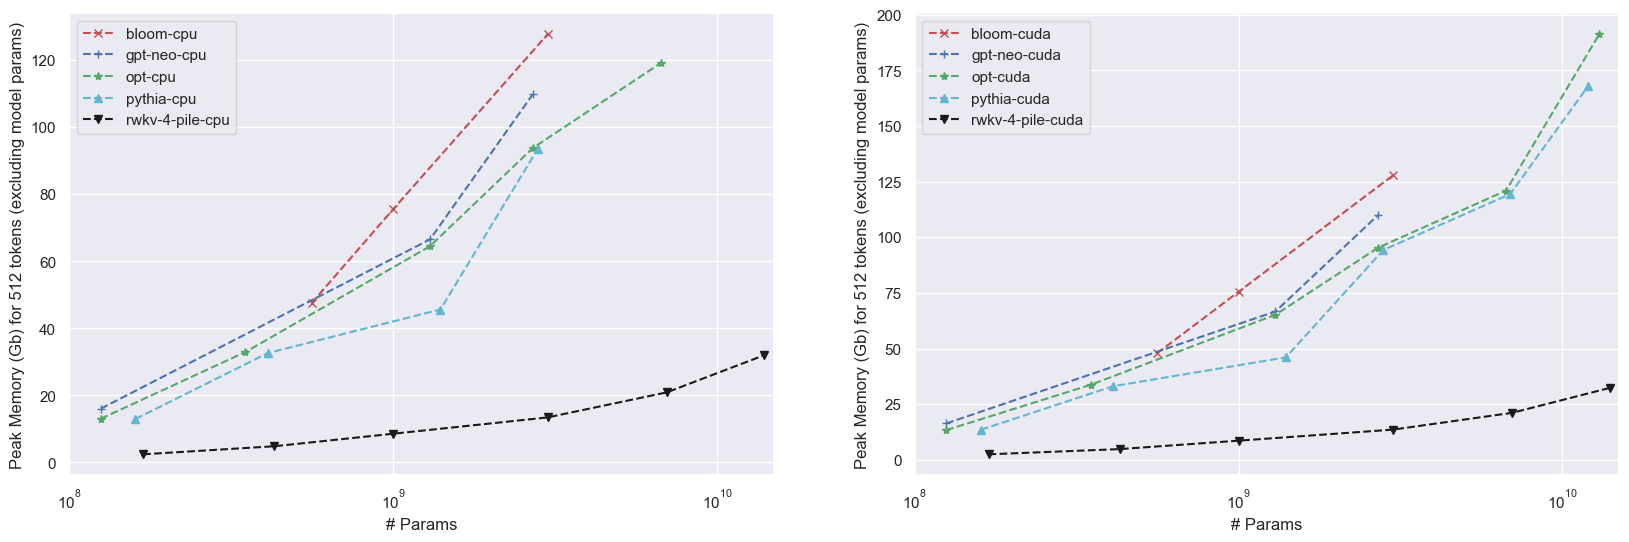

In [408]:
colors = "rbgck"
icons = "x+*^v"
alpha = {"cpu": 0.5, "cuda": 1.0}

fig, axs = plt.subplots(1, 2, figsize=(20, 6))

for i, (class_, model_df) in enumerate(main_df.groupby("class")): 
    for s, strategy in enumerate(["cpu", "cuda"]):
        mask = model_df["strategy"] == strategy
        axs[s].plot(model_df[mask]["size"], model_df[mask]["memory"]*10**(-8), f'{colors[i]}{icons[i]}--', label=f"{class_}-{strategy}") # , alpha=alpha[strategy])

for s in [0, 1]: 
    axs[s].legend()
    axs[s].set_xscale("log")
    # axs[s].set_yscale("log")
    axs[s].set_xlabel("# Params")
    axs[s].set_ylabel(f"Peak Memory (Gb) for {max_toks} tokens (excluding model params)")
    axs[s].set_xlim(10**8, 1.5*10**10)

In [15]:
rwkv_model_memory = df_rwkv[(df_rwkv["model_name"].str.contains('rwkv')) & (df_rwkv["strategy"].str.contains('cuda'))]
rwkv_model_memory['self_cuda_memory_usage'] = rwkv_model_memory['self_cuda_memory_usage'].abs()

/tmp/ipykernel_372/2820822441.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rwkv_model_memory['self_cuda_memory_usage'] = rwkv_model_memory['self_cuda_memory_usage'].abs()


model_name
BlinkDL/rwkv-4-pile-14b     Axes(0.125,0.11;0.775x0.77)
BlinkDL/rwkv-4-pile-169m    Axes(0.125,0.11;0.775x0.77)
BlinkDL/rwkv-4-pile-1b5     Axes(0.125,0.11;0.775x0.77)
BlinkDL/rwkv-4-pile-3b      Axes(0.125,0.11;0.775x0.77)
BlinkDL/rwkv-4-pile-430m    Axes(0.125,0.11;0.775x0.77)
BlinkDL/rwkv-4-pile-7b      Axes(0.125,0.11;0.775x0.77)
Name: self_cuda_memory_usage, dtype: object

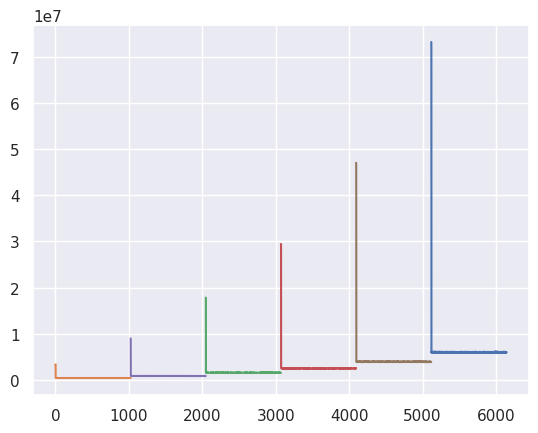

In [16]:
rwkv_model_memory.groupby('model_name')['self_cuda_memory_usage'].plot()